Истинное α: 1.6
Оценённое α (метод 1): 1.6229
Оценённое α (метод 2): 1.5902
Оценённое среднее (mu): -5.1225
Оценённое стандартное отклонение (sigma): 23.8537


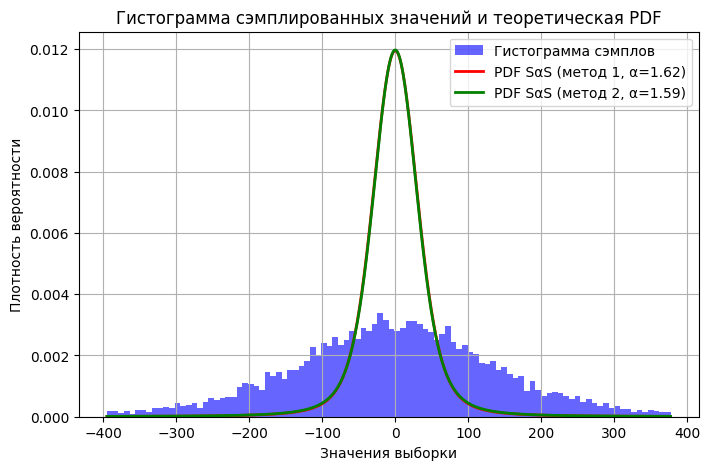

In [1]:
import numpy as np
import torch
import math
import scipy.stats as st
import matplotlib.pyplot as plt

def sample_alpha_stable(alpha, mu, sigma, size):
    """
    Генерирует выборку из SαS(σ) распределения с заданными α, μ, σ и размером выборки.
    """
    if sigma <= 0:
        raise ValueError("Параметр sigma должен быть положительным.")
    return torch.tensor(st.levy_stable.rvs(alpha, mu, scale=sigma, size=size), dtype=torch.float32)


def alpha_estimator(m, X):
    """
    Оценка параметра α согласно Corollary 2.4 из Mohammadi (2014).
    """
    N = len(X)
    n = N // m  # Количество групп
    Y = torch.sum(X.view(n, m, -1), dim=1)  # Группировка и суммирование

    eps = np.finfo(float).eps  # Маленькое число для защиты от логарифма 0
    Y_log_norm = torch.log(Y.norm(dim=1) + eps).mean()
    X_log_norm = torch.log(X.norm(dim=1) + eps).mean()
    
    diff = (Y_log_norm - X_log_norm) / math.log(m)
    
    return float(np.clip(1 / diff, a_min = 0 , a_max = 2))

def alpha_estimator2(m, k, X):
    """
    Оценка параметра α согласно Corollary 2.2 из Mohammadi (2014).
    """
    N = len(X)
    n = int(N / m)  # Размер группы
    Y = torch.sum(X.view(n, m, -1), 1)
    eps = np.spacing(1)
    
    Y_log_norm = torch.log(Y.norm(dim=1) + eps)
    X_log_norm = torch.log(X.norm(dim=1) + eps)

    # Выбираем k-й элемент после сортировки
    Yk = torch.sort(Y_log_norm)[0][k - 1]
    Xk = torch.sort(X_log_norm)[0][m * k - 1]
    
    diff = (Yk - Xk) / math.log(m)
    
    return float(np.clip(1 / diff, a_min = 0 , a_max = 2))

# Параметры распределения
true_alpha = 1.6
mu_init = 0  # Инициализация среднего
sigma_init = 100  # Инициализация стандартного отклонения
N = 10000  # Количество точек
d = 1  # Размерность данных
m = 100  # Размер группы для метода оценки
k = 40  # Параметр k для второго метода

# Генерация данных
X = sample_alpha_stable(true_alpha, mu_init, sigma_init, (N, d))

# Оценка α с использованием первого метода
estimated_alpha1 = alpha_estimator(m, X)

# Оценка α с использованием второго метода
estimated_alpha2 = alpha_estimator2(m, k, X)

# Оценка среднего и стандартного отклонения для гауссовых данных
mu_est = np.mean(X.numpy())  # Оценка среднего
sigma_est = np.sqrt(np.std(X.numpy())*np.sqrt(2))  # Оценка стандартного отклонения

# Вывод результатов
print(f"Истинное α: {true_alpha}")
print(f"Оценённое α (метод 1): {estimated_alpha1:.4f}")
print(f"Оценённое α (метод 2): {estimated_alpha2:.4f}")
print(f"Оценённое среднее (mu): {mu_est:.4f}")
print(f"Оценённое стандартное отклонение (sigma): {sigma_est:.4f}")

# Визуализация гистограммы и PDF
X_np = X.numpy().flatten()  # Преобразуем тензор в numpy-массив

# Определяем границы для сужения области (например, на 95% от диапазона данных)
lower_bound = np.percentile(X_np, 2.5)
upper_bound = np.percentile(X_np, 97.5)

# Фильтруем данные для гистограммы и PDF
filtered_X = X_np[(X_np >= lower_bound) & (X_np <= upper_bound)]

# Построение гистограммы
plt.figure(figsize=(8, 5))
plt.hist(filtered_X, bins=100, density=True, alpha=0.6, color='blue', label="Гистограмма сэмплов")

# Оценка PDF для первого метода
pdf_vals1 = st.levy_stable.pdf(np.linspace(lower_bound, upper_bound, 1000), estimated_alpha1, 0, scale=sigma_est)
# Оценка PDF для второго метода
pdf_vals2 = st.levy_stable.pdf(np.linspace(lower_bound, upper_bound, 1000), estimated_alpha2, 0, scale=sigma_est)

# Проверяем, есть ли NaN или бесконечности
pdf_vals1 = np.nan_to_num(pdf_vals1, nan=0.0, posinf=0.0, neginf=0.0)
pdf_vals2 = np.nan_to_num(pdf_vals2, nan=0.0, posinf=0.0, neginf=0.0)

# Построение теоретической PDF для обоих методов
plt.plot(np.linspace(lower_bound, upper_bound, 1000), pdf_vals1, 'r', lw=2, label=f"PDF SαS (метод 1, α={estimated_alpha1:.2f})")
plt.plot(np.linspace(lower_bound, upper_bound, 1000), pdf_vals2, 'g', lw=2, label=f"PDF SαS (метод 2, α={estimated_alpha2:.2f})")

# Подписи
plt.xlabel("Значения выборки")
plt.ylabel("Плотность вероятности")
plt.title("Гистограмма сэмплированных значений и теоретическая PDF")
plt.legend()
plt.grid()
plt.show()


In [2]:
X.shape

torch.Size([10000, 1])

##  Оценим альфы для гаусовского

Оценённое α (метод 1, гауссовские данные): 1.9607
Оценённое α (метод 2, гауссовские данные): 1.9422


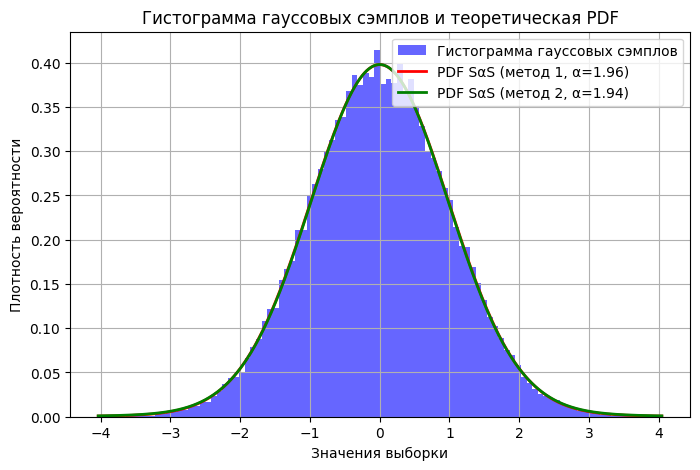

In [77]:
N = 10000  # Количество точек
d = 5  # Размерность данных
m = 10  # Размер группы для метода оценки
k = 40  # Параметр k для второго метода

# Генерация гауссовских случайных векторов
mean = 0
cov = np.eye(d)  # Единичная матрица для ковариационной матрицы
X_gaussian = np.random.multivariate_normal(mean=np.zeros(d), cov=cov, size=N)

# Преобразуем в тензор
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32)

# Оценка α для гауссовых векторов с использованием первого метода
estimated_alpha_gaussian1 = alpha_estimator(m, X_gaussian)

# Оценка α для гауссовых векторов с использованием второго метода
estimated_alpha_gaussian2 = alpha_estimator2(m, k, X_gaussian)

# Вывод результатов
print(f"Оценённое α (метод 1, гауссовские данные): {estimated_alpha_gaussian1:.4f}")
print(f"Оценённое α (метод 2, гауссовские данные): {estimated_alpha_gaussian2:.4f}")

# Визуализация гистограммы и PDF для гауссовских данных
X_gaussian_np = X_gaussian.numpy().flatten()  # Преобразуем тензор в numpy-массив

# Оценка среднего и стандартного отклонения для гауссовых данных
mu_est = np.mean(X_gaussian_np)  # Оценка среднего
sigma_est = np.std(X_gaussian_np)  # Оценка стандартного отклонения

sigma_est = sigma_est / np.sqrt(2)

# Построение гистограммы без фильтрации
plt.figure(figsize=(8, 5))
plt.hist(X_gaussian_np, bins=100, density=True, alpha=0.6, color='blue', label="Гистограмма гауссовых сэмплов")

# Оценка PDF для первого метода с оцененными параметрами (mu и sigma)
pdf_vals_gaussian1 = st.levy_stable.pdf(np.linspace(np.min(X_gaussian_np), np.max(X_gaussian_np), 1000), estimated_alpha_gaussian1, mu_est, scale=sigma_est)
# Оценка PDF для второго метода с оцененными параметрами (mu и sigma)
pdf_vals_gaussian2 = st.levy_stable.pdf(np.linspace(np.min(X_gaussian_np), np.max(X_gaussian_np), 1000), estimated_alpha_gaussian2, mu_est, scale=sigma_est)

# Проверяем, есть ли NaN или бесконечности
pdf_vals_gaussian1 = np.nan_to_num(pdf_vals_gaussian1, nan=0.0, posinf=0.0, neginf=0.0)
pdf_vals_gaussian2 = np.nan_to_num(pdf_vals_gaussian2, nan=0.0, posinf=0.0, neginf=0.0)

# Построение теоретической PDF для обоих методов
plt.plot(np.linspace(np.min(X_gaussian_np), np.max(X_gaussian_np), 1000), pdf_vals_gaussian1, 'r', lw=2, label=f"PDF SαS (метод 1, α={estimated_alpha_gaussian1:.2f})")
plt.plot(np.linspace(np.min(X_gaussian_np), np.max(X_gaussian_np), 1000), pdf_vals_gaussian2, 'g', lw=2, label=f"PDF SαS (метод 2, α={estimated_alpha_gaussian2:.2f})")

# Подписи
plt.xlabel("Значения выборки")
plt.ylabel("Плотность вероятности")
plt.title("Гистограмма гауссовых сэмплов и теоретическая PDF")
plt.legend()
plt.grid()
plt.show()


In [74]:
sigma_est

np.float32(1.0000302)